In [1]:
import torch
import torch.nn as nn
import pandas as pd
import os
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
from torchvision import models
import math
import torch.optim as optim


# Get all images, bbox and names on one dataframe

In [2]:
# tree
tree = pd.read_csv("/kaggle/input/veg-house/Vegetation.v1i.tensorflow/train/_annotations.csv")
start_fn ='/kaggle/input/veg-house/Vegetation.v1i.tensorflow/train'
# tree['label']= 'tree'
fn = tree['filename'].apply(lambda x: os.path.join(start_fn, x))
tree['filename'] = fn
Image.open(tree['filename'][10]).convert('RGB')

# # house 
house = pd.read_csv("/kaggle/input/veg-house/house.v1i.tensorflow/train/_annotations.csv")
# house['label']= 'house'
start_fn ='/kaggle/input/veg-house/house.v1i.tensorflow/train/'
fn = house['filename'].apply(lambda x: os.path.join(start_fn, x))
house['filename'] = fn
Image.open(house['filename'][10]).convert('RGB')


obstacle= pd.concat([tree, house], ignore_index=True)
obstacle= obstacle.sample(frac=1,ignore_index=True)  # Shuffle the DataFrame

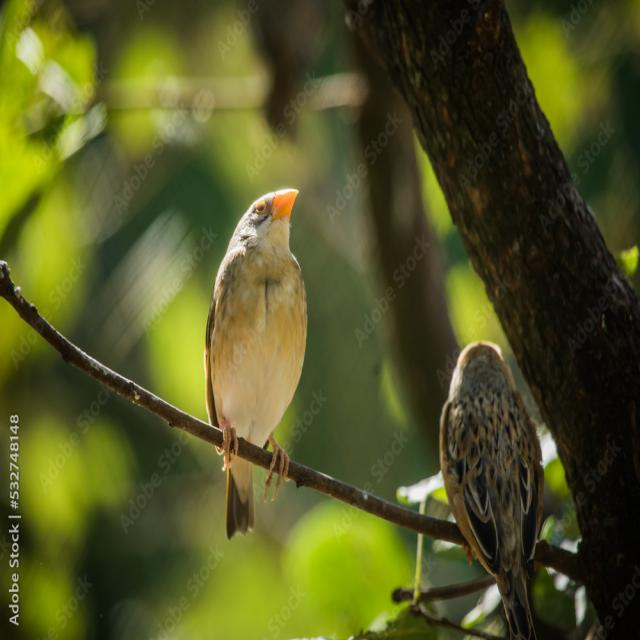

In [3]:
import xml.etree.ElementTree as ET

birds = '/kaggle/input/veg-house/annotations.xml'

def parse_xml(xml_file):
    etree = ET.parse(xml_file)
    root = etree.getroot()
    items = []

    # Iterate through each image element
    for image in root.findall('image'):
        img_width = int(image.attrib.get('width', 0))
        img_height = int(image.attrib.get('height', 0))
        img_name = image.attrib.get('name')

        # Loop through each object in the image
        for obj in image.findall('box'):
            label = obj.attrib.get('label')
            xtl = float(obj.attrib.get('xtl'))
            ytl = float(obj.attrib.get('ytl'))
            xbr = float(obj.attrib.get('xbr'))
            ybr = float(obj.attrib.get('ybr'))

            items.append({
                'image': img_name,
                'label': label,
                'width': img_width,
                'height': img_height,
                'xtl': xtl,
                'ytl': ytl,
                'xbr': xbr,
                'ybr': ybr
            })

    df = pd.DataFrame(items)
    return df

quelea = parse_xml(birds)
start_fn ='/kaggle/input/veg-house/select'
fn = quelea['image'].apply(lambda x: os.path.join(start_fn,x))
quelea['image'] = fn

Image.open(quelea['image'][10]).convert('RGB')

In [4]:
obstacle.columns, quelea.columns

(Index(['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax'], dtype='object'),
 Index(['image', 'label', 'width', 'height', 'xtl', 'ytl', 'xbr', 'ybr'], dtype='object'))

In [5]:
# # quelea['label'] = 'quelea'
# quelea.head()

In [6]:
quelea= quelea.rename(columns={'image':'filename', 'label':'class','xtl':'xmin','ytl':'ymin','xbr':'xmax','ybr':'ymax'})
quelea.columns

Index(['filename', 'class', 'width', 'height', 'xmin', 'ymin', 'xmax', 'ymax'], dtype='object')

In [7]:
#replace xmin: with x, ymin with y
# concat obstacle and quelea
# shuffle the DataFrame
quelea =quelea[obstacle.columns]
all_data = pd.concat([obstacle, quelea], ignore_index=True)
all_data = all_data.sample(frac=1, ignore_index=True)  
all_data= all_data.rename(columns={'xmin':'x', 'ymin':'y'})

In [8]:
# calculate bounding box width and height
b_with= [ round(i,1) for  i in all_data['xmax'] - all_data['x']]
b_height = [round(i,1) for i in all_data['ymax'] - all_data['y']]
all_data['b_width'] = b_with
all_data['b_height'] = b_height
all_data

,filename,width,height,class,x,y,xmax,ymax,b_width,b_height
0,/kaggle/input/veg-house/Vegetation.v1i.tensorf...,1024,321,Tree,255.0,0.0,652.0,159.0,397.0,159.0
1,/kaggle/input/veg-house/Vegetation.v1i.tensorf...,1024,768,Tree,0.0,106.0,544.0,586.0,544.0,480.0
2,/kaggle/input/veg-house/Vegetation.v1i.tensorf...,1024,768,Tree,224.0,443.0,252.0,499.0,28.0,56.0
3,/kaggle/input/veg-house/Vegetation.v1i.tensorf...,1024,1024,Tree,73.0,383.0,102.0,404.0,29.0,21.0
4,/kaggle/input/veg-house/Vegetation.v1i.tensorf...,1024,680,Tree,995.0,74.0,1023.0,382.0,28.0,308.0
...,...,...,...,...,...,...,...,...,...,...
3838,/kaggle/input/veg-house/Vegetation.v1i.tensorf...,1024,682,Tree,112.0,415.0,462.0,460.0,350.0,45.0
3839,/kaggle/input/veg-house/Vegetation.v1i.tensorf...,1024,768,Tree,636.0,464.0,666.0,485.0,30.0,21.0
3840,/kaggle/input/veg-house/Vegetation.v1i.tensorf...,1024,681,Tree,681.0,305.0,860.0,390.0,179.0,85.0
3841,/kaggle/input/veg-house/Vegetation.v1i.tensorf...,1024,768,Tree,0.0,0.0,1023.0,339.0,1023.0,339.0


In [9]:
# create label column by mapping class names to integers
labels=all_data['class'].unique()
labels
all_labels = {label:idx for idx , label in enumerate(labels)}
all_data['label'] =all_data['class'].map(all_labels)
all_data.head()

,filename,width,height,class,x,y,xmax,ymax,b_width,b_height,label
0,/kaggle/input/veg-house/Vegetation.v1i.tensorf...,1024,321,Tree,255.0,0.0,652.0,159.0,397.0,159.0,0
1,/kaggle/input/veg-house/Vegetation.v1i.tensorf...,1024,768,Tree,0.0,106.0,544.0,586.0,544.0,480.0,0
2,/kaggle/input/veg-house/Vegetation.v1i.tensorf...,1024,768,Tree,224.0,443.0,252.0,499.0,28.0,56.0,0
3,/kaggle/input/veg-house/Vegetation.v1i.tensorf...,1024,1024,Tree,73.0,383.0,102.0,404.0,29.0,21.0,0
4,/kaggle/input/veg-house/Vegetation.v1i.tensorf...,1024,680,Tree,995.0,74.0,1023.0,382.0,28.0,308.0,0


In [10]:
# all_data.to_csv('/kaggle/input/veg-house/data.csv', index=False)

# Data preparation

In [11]:
class CustomDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])
        self.num_classes = len(dataframe['class'].unique())
    def __len__(self):
        return self.dataframe.shape[0]
    def __getitem__(self, idx):
        row =self.dataframe.iloc[idx]
        # Load and preprocess the image
        image_path = row['filename']
        image = Image.open(image_path).convert('RGB')
        width, height =image.size
        # Apply transformations
        image = self.transform(image)
        x,y,w,h= row['x'], row['y'], row['b_width'],row['b_height']
        x,y = x+ w/2, y+h/2
        x,y,w,h= x/width,y/height,w/width,h/height

        # Convert label to one-hot encoding
        cls= torch.tensor(row['label'], dtype=torch.long)
        cls = nn.functional.one_hot(cls, num_classes=self.num_classes)
        return {
            'item': image.type(torch.float32),
            'gt':{
                'bbox': torch.Tensor([x,y,w,h]).type(torch.float32),
                'cls': cls.type(torch.float32)
            }
        }

In [12]:
train_data= all_data.sample(frac=0.8, random_state=42).reset_index(drop=True)
val_data = all_data.drop(train_data.index).reset_index(drop=True)
train_dataset = CustomDataset(train_data)
val_dataset = CustomDataset(val_data)

batch_size = 32
train_loader= DataLoader(train_dataset,batch_size=batch_size,shuffle=True, num_workers=os.cpu_count(), prefetch_factor=2)
val_loader =DataLoader(val_dataset, batch_size=batch_size,shuffle=True, num_workers= os.cpu_count(), prefetch_factor=2)

for batch in train_loader:
    bbox= batch['gt']['bbox']
    cls = batch['gt']['cls']
    images = batch['item']
    print(f"Image batch shape: {images.shape}")
    print(f"Bounding box batch shape: {bbox.shape}")
    print(f"Class batch shape: {cls.shape}")
    break

Image batch shape: torch.Size([32, 3, 224, 224])
Bounding box batch shape: torch.Size([32, 4])
Class batch shape: torch.Size([32, 3])


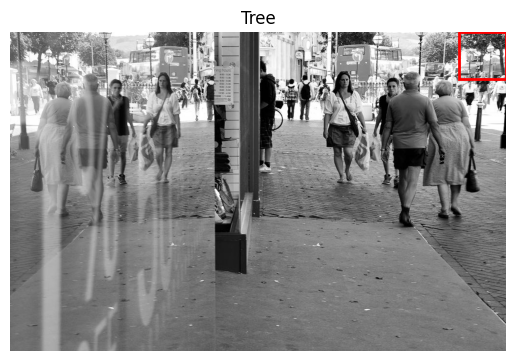

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches
from PIL import Image

def plot_image_with_boxes(image, title,center_x, center_y, width, height):
    plt.imshow(image)
    ax= plt.gca()
    bbox= patches.Rectangle((center_x,center_y), width, height, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(bbox)
    plt.title(title)
    plt.axis('off')
    plt.show()

idx= 1409
image_path = all_data.iloc[idx]['filename']
name= all_data.iloc[idx]['class']
image = Image.open(image_path).convert('RGB')
center_x = all_data.iloc[idx]['x']
center_y = all_data.iloc[idx]['y']
width = all_data.iloc[idx]['b_width']
height = all_data.iloc[idx]['b_height']
plot_image_with_boxes(image, name,center_x, center_y, width, height)


In [17]:
def is_contained(box1,box2):
    """
    Check if box1 is contained within box2.
    box1 and box2 are expected to be in the format [xmin, ymin, xmax, ymax].
    """
    x1_min, y1_min, x1_max, y1_max = box1
    x2_min, y2_min, x2_max, y2_max = box2
    return (x1_min <= x2_min <= x1_max and
            x1_min <= x2_max <= x1_max and
            y1_min <= y2_min <= y1_max and
            y1_min <= y2_max <= y1_max 
            )

def calculate_iou(box1, box2):
    xcenter_x1, center_y1, w1, h1 = box1
    xcenter_x2, center_y2, w2, h2 = box2

    x_min1= xcenter_x1 - w1 / 2
    y_min1 = center_y1 - h1 / 2
    x_min2 = xcenter_x2 - w2 / 2
    y_min2 = center_y2 - h2 / 2

    x_max1 = x_min1 + w1
    y_max1 = y_min1 + h1

    x_max2 = x_min2 + w2 
    y_max2 = y_min2 + h2

    # Calculate the intersection area
    if is_contained((x_min1, y_min1, x_max1, y_max1), (x_min2, y_min2, x_max2, y_max2)):
        return 1.0
    if is_contained((x_min2, y_min2, x_max2, y_max2), (x_min1, y_min1, x_max1, y_max1)):
        return 1.0
    inter_xmin = max(x_min1, x_min2)
    inter_ymin = max(y_min1, y_min2)
    inter_xmax = min(x_max1, x_max2)
    inter_ymax = min(y_max1, y_max2)
    inter_area = max(0, inter_xmax - inter_xmin) * max(0, inter_ymax - inter_ymin)
    # Calculate the union area
    box1_area = (x_max1 - x_min1) * (y_max1 - y_min1)
    box2_area = (x_max2 - x_min2) * (y_max2 - y_min2)
    union_area = box1_area + box2_area - inter_area
    # Calculate the IoU
    iou = inter_area / union_area if union_area > 0 else 0
    return iou

In [ ]:
import torch 
import torch.nn as nn
import torch.nn.functional as F

class CustomLoss:
    def __init__(self, eps=1e-6):
        self.eps =eps
        self.lambda_box = 1.0
        self.cls_loss_fn = nn.CrossEntropyLoss()
        #cls_loss = torch.mean(torch.sum(-cls_targets * F.log_softmax(cls_preds, dim=1), dim=1))
        self.box_loss_fn = nn.HuberLoss()
    def  loss(self, predictions, targets):
        """
        Calculate the loss between predictions and targets.
        predictions: A dictionary with keys 'bbox' and 'cls'.
        targets: A dictionary with keys 'bbox' and 'cls'.
        """
        bbox_preds = predictions['bbox']
        cls_preds= predictions['cls']
        bbox_targets = targets['bbox']
        cls_targets = targets['cls']

        # Calculate the classification loss
        cls_loss = torch.mean(torch.sum(-cls_targets * F.log_softmax(cls_preds, dim=1), dim=1))
        #cls_loss =self.cls_loss_fn(cls_preds, cls_targets)
        # Calculate the bounding box loss
        bbox_preds_sqrt = bbox_preds.clone()
        targets_boxes_sqrt = bbox_targets.clone()

        bbox_preds_sqrt[:,2:] = torch.sqrt(bbox_preds[:,2:].clamp(min=self.eps))
        targets_boxes_sqrt[:,2:] = torch.sqrt(bbox_targets[:,2:].clamp(min=self.eps))
        bbox_loss = self.box_loss_fn(bbox_preds_sqrt, targets_boxes_sqrt)
        # Combine the losses
        #total_loss = cls_loss + self.lambda_box * bbox_loss

        total_loss = cls_loss + self.lambda_box * bbox_loss
        return total_loss 


In [19]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.model = models.resnet18(pretrained=True)

        num_features = self.model.fc.in_features
        self.model.fc = nn.Identity()
        self.bbox_head = nn.Sequential(
            nn.Linear(num_features,512),
            nn.SiLU(inplace=True),
            nn.Linear(512, 4),  # Output for bounding box (x, y, width, height)
        )
        self.cls_head = nn.Sequential(
            nn.Linear(num_features,512),
            nn.SiLU(inplace=True),
            nn.Linear(512, len(all_data['class'].unique()))  # Output for class scores
        )
    def forward(self,x):
        x = self.model(x)
        bbox = self.bbox_head(x)
        cls = self.cls_head(x)
        
        outs = {
            'bbox': bbox,
            'cls': cls
        }
        return outs

In [ ]:
model = MyModel().to(torch.float32)
device =torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)          

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 172MB/s] 


In [ ]:
print(model)

In [22]:
def train_model(model, train_loader, val_loader,optimizer, loss_fn):
    model.train()
    total_loss = 0.0
    for batch_idx, batch in enumerate(train_loader):
        inputs = batch['item'].to(device)
        outputs = {'bbox': batch['gt']['bbox'].to(device),
                   'cls': batch['gt']['cls'].to(device)}
        
        #forward pass
        predictions = model(inputs)
        loass = loss_fn.loss(predictions, outputs)

        # Backward pass and optimization
        optimizer.zero_grad()
        loass.backward()
        optimizer.step()

        # track the loss
        total_loss += loass.item()
    average_loss = total_loss / len(train_loader)
    return average_loss


In [23]:
def validate_one_epoch(model, val_loader, loss_fn):
    model.eval()
    total_loss = 0.0
    total_iou = 0.0
    total_acc= 0.0

    with torch.no_grad():
        for batch_idx, batch in enumerate(val_loader):
            inputs = batch['item'].to(device)
            outputs = {
                'bbox': batch['gt']['bbox'].to(device),
                'cls': batch['gt']['cls'].to(device)
            }

            # Forward pass
            predictions = model(inputs)
            # Calculate loss
            loss = loss_fn.loss(predictions, outputs)
            total_loss += loss.item()

            # Calculate IoU and accuracy
            iou = sum(calculate_iou(predictions['bbox'][i], outputs['bbox'][i]) if predictions['cls'][i].argmax() == outputs['cls'][i].argmax()
                      else calculate_iou(predictions['bbox'][i], outputs['bbox'][i]) 
                      for i in range(len(predictions['bbox'])))
            avg_iou = iou / len(predictions['bbox'])
            acc = sum(
                1.0 if predictions['cls'][i].argmax() == outputs['cls'][i].argmax() else 0.0
                for i in range(len(predictions['bbox'])))
            acc/= len(predictions['bbox'])
            total_iou += avg_iou
            total_acc += acc

            avg_iou = total_iou / len(val_loader)
            avg_loss = total_loss / len(val_loader)
            avg_acc = total_acc / len(val_loader)

    return  avg_iou, avg_acc,avg_loss


In [24]:
device

device(type='cuda')

In [25]:
loss_fn = CustomLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 20
for epoch in range(1, epochs+1):
    print(f"Epoch {epoch}/{epochs}")
    # validation step
    val_iou, val_acc, valid_loss = validate_one_epoch(model, val_loader,loss_fn)
    print(f"Validation IoU: {val_iou:.4f}, Validation Accuracy: {val_acc:.4f}, Validation Loss: {valid_loss:.4f}")

    # ttraiining step
    train_loss = train_model(model, train_loader, val_loader, optimizer, loss_fn)
    print(f"Training Loss: {train_loss:.4f}")
    print(f"Epoch {epoch} completed.\n")
    print(f'\t Train Loss: {train_loss:.4f}, |Train PPL:{math.exp(train_loss):7.4f}')
    print(f'\t Val Loss: {valid_loss:.4f}, |Val PPL:{math.exp(valid_loss):7.4f}')
    

Epoch 1/20
Validation IoU: 0.0654, Validation Accuracy: 0.3800, Validation Loss: 0.0504
Training Loss: 0.0071
Epoch 1 completed.

	 Train Loss: 0.0071, |Train PPL: 1.0071
	 Val Loss: 0.0504, |Val PPL: 1.0517
Epoch 2/20
Validation IoU: 0.0350, Validation Accuracy: 0.9788, Validation Loss: 0.0004
Training Loss: 0.0005
Epoch 2 completed.

	 Train Loss: 0.0005, |Train PPL: 1.0005
	 Val Loss: 0.0004, |Val PPL: 1.0004
Epoch 3/20
Validation IoU: 0.0562, Validation Accuracy: 0.9838, Validation Loss: 0.0003
Training Loss: 0.0005
Epoch 3 completed.

	 Train Loss: 0.0005, |Train PPL: 1.0005
	 Val Loss: 0.0003, |Val PPL: 1.0003
Epoch 4/20
Validation IoU: 0.0312, Validation Accuracy: 0.9350, Validation Loss: 0.0026
Training Loss: 0.0004
Epoch 4 completed.

	 Train Loss: 0.0004, |Train PPL: 1.0004
	 Val Loss: 0.0026, |Val PPL: 1.0026
Epoch 5/20
Validation IoU: 0.0750, Validation Accuracy: 0.9838, Validation Loss: 0.0001
Training Loss: 0.0001
Epoch 5 completed.

	 Train Loss: 0.0001, |Train PPL: 1.00

In [26]:
test_iou ,test_acc , test_loss = validate_one_epoch(model, val_loader, loss_fn=loss_fn)
print(f"Test IoU: {test_iou:.4f}, Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

Test IoU: 0.2231, Test Accuracy: 0.9688, Test Loss: 0.0003


In [27]:
torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    "epoch": epochs

}, "model_checkpoint.pth")

In [28]:
torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    "epoch": epochs

}, "/kaggle/working/model_checkpoint.pth")

In [61]:
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],  
                                 std=[0.229, 0.224, 0.225])
    ])

    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)
    return image

def predict_and_draw(image_path):
    image = preprocess_image(image_path)

    # get predictions
    with torch.no_grad():
        output = model(image)
        bbox = output['bbox'].squeeze(0).cpu().numpy() # remove batch demension and move to CPU
        cls = output['cls'].squeeze(0).cpu().numpy() # Get class predictions

    ori_image = Image.open(image_path).convert('RGB')
    # print(bbox)
    # print(ori_image.size)

    x_center, y_center, width, height = bbox
    x_center, y_center, width, height = x_center*ori_image.size[0],y_center*ori_image.size[1], width*ori_image.size[0], height*ori_image.size[1]

    x_min =(x_center - width/2)
    y_min = (y_center - height/2)
    x_max = (x_center + width/2)
    y_max = (y_center + width/2)

    pred_class =np.argmax(cls)
    idx_to_class = {v: k for k, v in all_labels.items()}
    pred_name = idx_to_class[pred_class]

    # plot image and bbox
    image = Image.open(image_path)
    plt.imshow(np.array(image))
    plt.axis('off')
    plt.gca().add_patch(plt.Rectangle((x_min, y_min), width, height, fill=False, color='red', linewidth=2))
    plt.title(f'Predicted Class: {pred_name}')
    plt.show()

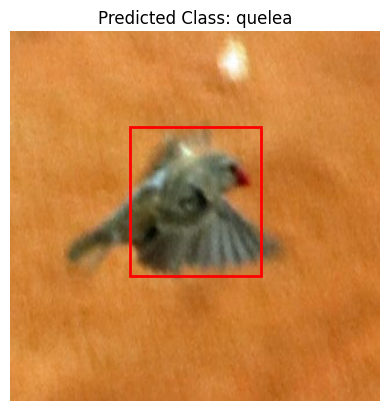

In [62]:
predict_and_draw(all_data['filename'][900])

In [63]:
# import matplotlib.patches as patches
# plt.figure(figsize=(12,12))
# for idx,image in enumerate(val_images[:50]):
#     plt.subplot(5,10,idx+1)
#     plt.imshow(image)
#     plt.axis('off')
#     plt.title(pred_labels[idx])

#     a,b,c,d= pred_bbox[idx]

#     x=a*480
#     y=b*480
#     w=c*480
#     h=d*480
#     ax=plt.gca()
#     rect=patches.Rectangle((x,y),w,h,linewidth=2,edgecolor='r',facecolor='none')
#     ax.add_patch(rect)

# plt.tight_layout()

# plt.show()


In [75]:
def predict_and_draw(fn):
    plt.figure(figsize=(12,12))
    for idx, fn_p in enumerate(fn):
        plt.subplot(5,10,idx+1)
        image = preprocess_image(fn_p)
    
        # get predictions
        with torch.no_grad():
            output = model(image)
            bbox = output['bbox'].squeeze(0).cpu().numpy() # remove batch demension and move to CPU
            cls = output['cls'].squeeze(0).cpu().numpy() # Get class predictions
    
        ori_image = Image.open(fn_p).convert('RGB')
        # print(bbox)
        # print(ori_image.size)
    
        x_center, y_center, width, height = bbox
        x_center, y_center, width, height = x_center*ori_image.size[0],y_center*ori_image.size[1], width*ori_image.size[0], height*ori_image.size[1]
    
        x_min =(x_center - width/2)
        y_min = (y_center - height/2)
        x_max = (x_center + width/2)
        y_max = (y_center + width/2)
    
        pred_class =np.argmax(cls)
        idx_to_class = {v: k for k, v in all_labels.items()}
        pred_name = idx_to_class[pred_class]
    
        # plot image and bbox
        image = Image.open(fn_p)
        plt.imshow(np.array(image))
        plt.axis('off')
        
        plt.gca().add_patch(plt.Rectangle((x_min, y_min), width, height, fill=False, color='red', linewidth=2))
        plt.title(pred_name)
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

In [77]:
fn_p= all_data['filename'][150:150]
predict_and_draw(fn_p)

<Figure size 1200x1200 with 0 Axes>